In [3]:
!conda install micromamba -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - micromamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    micromamba-0.15.3          |                0         5.3 MB  conda-forge
    openssl-1.1.1l             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.4 MB

The following NEW packages will be INSTALLED:

  micromamba         conda-forge/linux-64::micromamba-0.15.3-0

The following packages will be UPDATED:

  openssl                                 1.1.1k-h7f98852_1 --> 1.1.1l-h7f98852_0



openssl-1.1.1l       | 2.1 MB    | ##################################### | 100% 
micromamba-0.15.3    | 5.3 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying trans

In [4]:
!source activate base && micromamba install cartopy pyproj xarray fsspec boto3 h5netcdf s3fs -y -c conda-forge


                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

conda-forge/linux-64     Using cache
conda-forge/noarch       Using cache

Pinned packages:
  - conda 4.10.3
  - python 3.9.6
  - python 3.9.*


Transaction

  Prefix: /opt/conda

  Updating specs:

   - cartopy
   - pyproj
   - xarray
   - fsspec
   - boto3
   - h5netcdf
   - s3fs


  Package             Version  Build                   Channel                    Size
────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────

  + boto3             1.18.45  pyhd8ed1ab_0            conda-forge/noarch       Cached
  + botocore          1.21.45  pyhd8ed1ab_0            conda-forge/noarch   

In [5]:
%matplotlib inline
import xarray as xr
import boto3
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cartopy, cartopy.crs as ccrs
from botocore import UNSIGNED
from botocore.client import Config

In [6]:
def get_url_for_prefix(prefix):
    s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket = 'noaa-goes16', Prefix = prefix)


    files_mapper = ["s3://noaa-goes16/" + file['Key'] for page in page_iterator for file in page['Contents']]
    return files_mapper[1]

get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01')

's3://noaa-goes16/ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01_G16_s20210011806176_e20210011808549_c20210011809018.nc'

In [7]:
blue_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01')
blue_ds = xr.open_dataset(fsspec.open(blue_url, anon=True).open())
blue_ds

<xarray.Dataset>
Dimensions:                                           (y: 3000, x: 5000, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-01-01T18:06:17.6Z
    time_coverage_end:         2021-01-01T18:08:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        01c42375-da6d-4635-8f1f-7fbf0f4b31f0

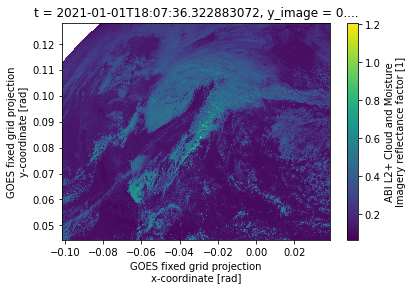

In [8]:
blue_ds['CMI'].plot()

In [9]:
red_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C02')
red_ds = xr.open_dataset(fsspec.open(red_url, anon=True).open())
veggie_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C03')
veggie_ds = xr.open_dataset(fsspec.open(veggie_url, anon=True).open())

In [10]:
display(red_ds['CMI'].values.shape)
display(veggie_ds['CMI'].values.shape)
display(blue_ds['CMI'].values.shape)

(6000, 10000)

(3000, 5000)

(3000, 5000)

In [11]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [12]:
red_1km = rebin(red_ds['CMI'].values, [3000, 5000])

In [13]:
red_1km.shape

(3000, 5000)

In [14]:
veggie_1km = veggie_ds['CMI'].values
blue_1km = blue_ds['CMI'].values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


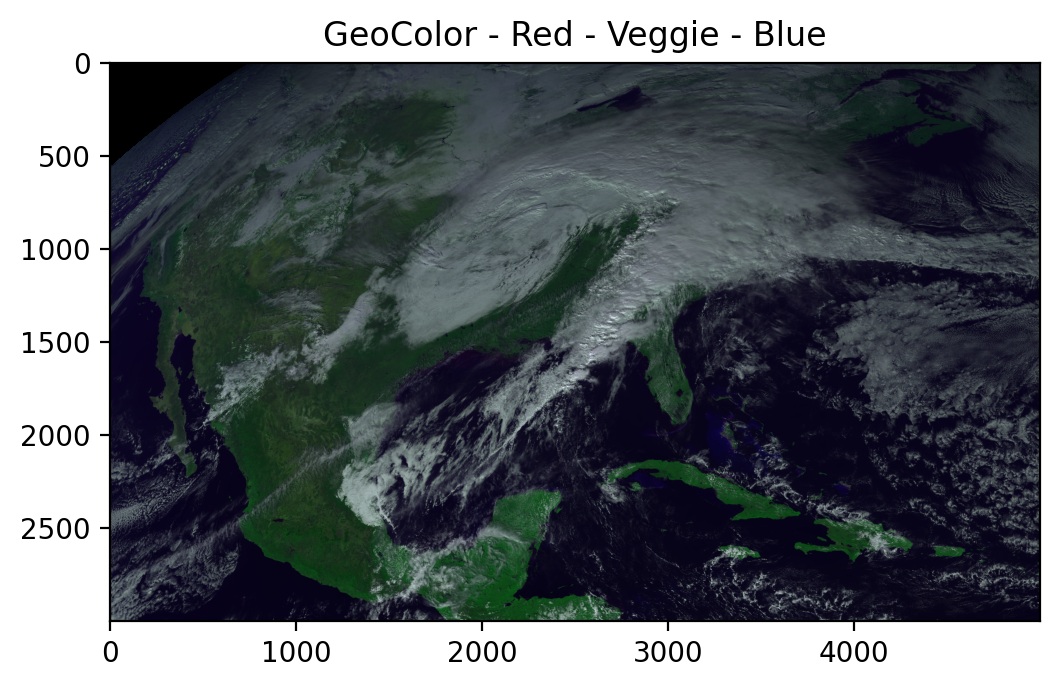

In [15]:
geocolor = np.stack([red_1km, veggie_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

In [16]:
green_1km = 0.48358168 * veggie_1km + 0.45706946 * red_1km + 0.06038137 * blue_1km

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


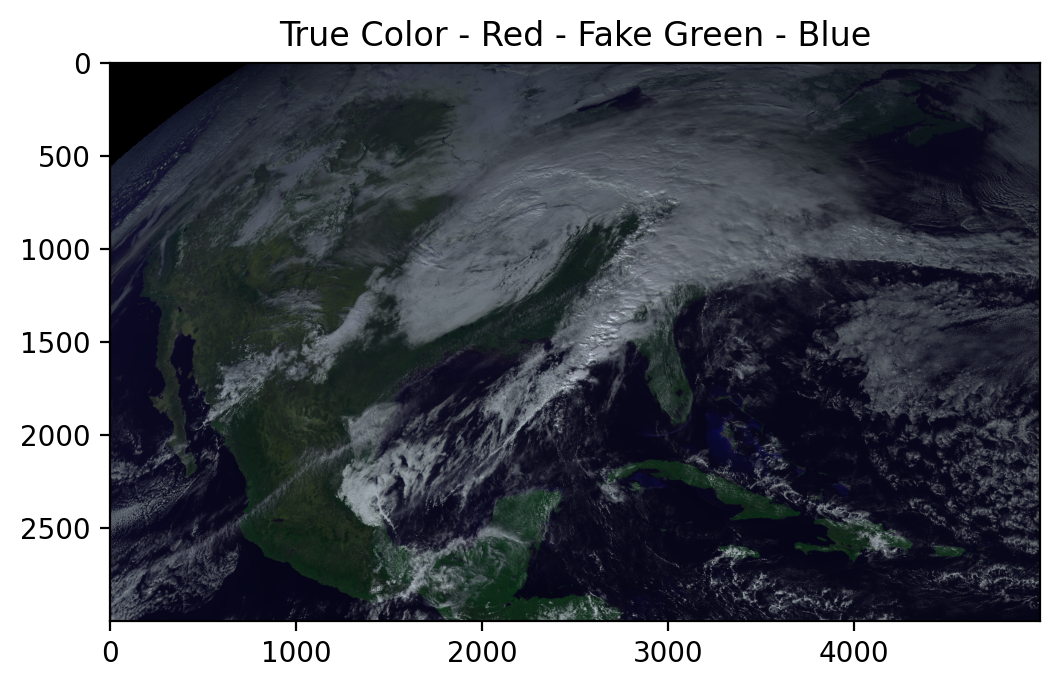

In [17]:
truecolor = np.stack([red_1km, green_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(truecolor)
plt.title('True Color - Red - Fake Green - Blue')
plt.show()